## prequisite : make dct2, design measure basis

In [18]:
using FFTW, LinearAlgebra, Distributions, Random

In [2]:
#=
no need to make dct2 manually; if dct a matrix, it returns dct automatically
function idct2(matrix, padding = false)
    
    if padding == false
        (R, C) = size(matrix);
        return idct(idct(matrix')');
    else
        (R, C) = Tuple(padding);
        return idct(idct(matrix'[1:R, :])[1:C,:]');
    end
end
=#
a = [1 2 3; 2 3 4];
a_ = idct(a[1:2,1:2]);   # it returns a dct2 result  

In [40]:
## 1.
function idctmtx(dims)
    ## produce a DCT matrix like matlab
    diag = I(dims);
    D = zeros(dims,dims);
    for i = 1:dims
        D[:,i] = idct(diag[:,i]);
    end
    return D;
end

## 2.
function DCT_basis(r_tot,c_tot)
    ## produce a hyper resolution DMD measurement basis series
    ##verified by Python; 
    # making a idct2 matrix in a vector form
    D1 = idctmtx(r_tot);
    D2 = idctmtx(c_tot);
    N = r_tot * c_tot;
    Basis = zeros(N,N);
    
    i = 1;
    for ir = 1:r_tot
        for ic = 1:c_tot
            
            Basis_Vector = D1[ir:ir,:]' * D2[ic:ic,:];
            Basis[i,:] = reshape(Basis_Vector', (1,:));
            i += 1;
        end
    end
    return Basis;
end

## 3.
function Poisson_noise(signal)
    return rand.(Poisson.(signal));
end

## 4. This two functions are genrating a 0-1 Walsh Matrix
## for compressed sensing, just select part of this rows
function DMD_freq_pattern_old(r,c, cycles = false)
    if cycles == false || cycles < 0 || cycles > r*c;
        cycles = r*c;
    end
    
    freq_pattern = zeros(r,c);
    ratio = (cycles/r/c)^0.5;
    
    r1 = Int(ceil(ratio * r))-1;
    c1 = Int(ceil(ratio * c))-1;
    
    freq_pattern[1:r1, 1:c1] .= 1;
    
    n_res = cycles - r1 * c1;
    res_index = findall(x->x == 0, freq_pattern[1:r1+1, 1:c1+1]);
    
    index_distance = zeros(length(res_index), 2);
    
    for i = 1:length(res_index)
        index_distance[i,1] = i;
        # res_index[i] is a tuple
        index_distance[i,2] = res_index[i][1]/(r1+0.0) + res_index[i][2]/(c1+0.0);
    end
    
    sorted_index_distance = index_distance[sortperm(index_distance[:,2]),:];
    selected_index = sorted_index_distance[:,1][1:n_res];
    
    for i = 1:n_res
        rc_cartesian = res_index[Int(selected_index[i])];
        freq_pattern[rc_cartesian[1], rc_cartesian[2]] = 1;
    end
    
    return freq_pattern;
    
end

function DMD_freq_pattern(r,c, cycles = false)
     if cycles == false || cycles < 0 || cycles > r*c;
        cycles = r*c;
    end
    
    freq_pattern = zeros(r,c);
    n_res = cycles;
    res_index = findall(x->x == 0, freq_pattern);
    
    
    index_distance = zeros(length(res_index), 2);
    
    for i = 1:length(res_index)
        index_distance[i,1] = i;
        # res_index[i] is a tuple
        index_distance[i,2] = res_index[i][1]/(r+0.0) + res_index[i][2]/(c+0.0);
    end
    
    sorted_index_distance = index_distance[sortperm(index_distance[:,2]),:];
    selected_index = sorted_index_distance[:,1][1:n_res];
    
    for i = 1:n_res
        rc_cartesian = res_index[Int(selected_index[i])];
        freq_pattern[rc_cartesian[1], rc_cartesian[2]] = 1;
    end
    
    return freq_pattern;
end

## 5
function DMD_measure_basis(r, c, cycles = false)
    ## it returns a DMD 0-1 matrix as measure basis
    ## this matrix has "cycles" rows and "r*c" columns
    if cycles == false
        cycles = r*c;
    end
    DMD_basis = zeros(cycles, r*c);
    #freq_pattern = DMD_freq_pattern(r,c, cycles);
    freq_pattern = ones(r*c, r*c);
    
    #rows = 1:r*c;
    #rows_selected = randperm(rows)[1:cycles]; 
    
    index_total = findall(x->x==1.0, freq_pattern);
    index = index_total[randperm(cycles)];
    FT_domain = zeros(r,c);
    for i = 1:length(index)
        current_index = index[i];
        FT_domain[current_index[1], current_index[2]] = 1;
        DMD_zero_one = ceil.(idct(FT_domain)); ## 0-1 pattern on DMD
        
        DMD_basis[i,:] = reshape(DMD_zero_one',(1,:));
        FT_domain[current_index[1], current_index[2]] = 0;
    end
    return DMD_basis;
end

## 6 direct upload a black white image and get the measurement
function PMT_measure_simu(photon_number, cycles, upload_image, upload_basis, Poisson = true)
    ### photon - number is the photons of each pixel during each measurement
    ### cycles : the compression rate; 
    ### Poisson : true, adding poisson noise
    ### upload_image : Black white image (matrix)
    image = upload_image / maximum(upload_image);
    r_tot, c_tot = size(upload_image);
    #=
    if upload_basis == "null"
        DMD_basis = DMD_measure_basis(r_tot, c_tot, cycles);
    else
        DMD_basis = upload_basis[1:cycles,:];
    end
    =#
    DMD_basis = upload_basis[1:cycles,:];
    
    image_vector = reshape(image', (:, 1));
    image_vector *= photon_number; ## here you are light up a image
    
    measurements = zeros(cycles,1); 
    ### if you want to do RGB image later, set zeros(cycles,3)
    
    for i = 1:cycles
        val = DMD_basis[i,:] * image_vector;
        
        if Poisson == true
            val = Poisson_noise(val);
        end
        measurement[i,:] = val;
    end
    
    measurements /= photon_number;
    
    return measurements;
end


PMT_measure_simu (generic function with 3 methods)

In [4]:
using Images, PyPlot

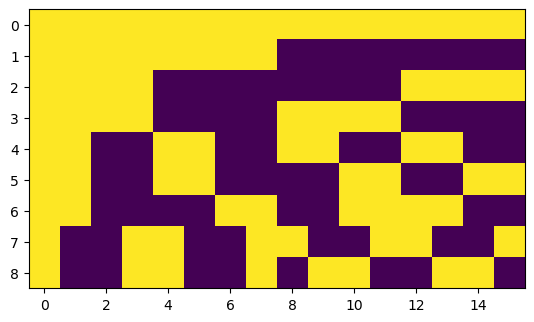

PyObject <matplotlib.image.AxesImage object at 0x000000005B4DC208>

In [5]:
imshow(DMD_measure_basis(4, 4, 9))

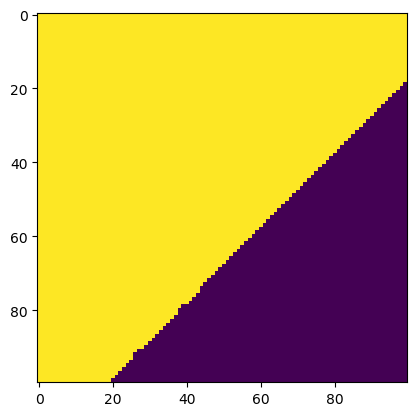

In [6]:
imshow(DMD_freq_pattern(100,100,6700));

In [34]:
mmm = [1 2 3; 4 5 6; 7 8 9];
rows = [1; 2; 3];
mmm / maximum(mmm)

3×3 Array{Float64,2}:
 0.111111  0.222222  0.333333
 0.444444  0.555556  0.666667
 0.777778  0.888889  1.0     

In [37]:
a = [1 2 3];
Poisson_noise(a.*10)
Poisson_noise(12)

13

In [22]:
a = [1 2 3;3 4 5;3 3 3];
ind = findall(x->x ==3, a)
## findall returns a Cartesian Index, like an array with tuples. Can


5-element Array{CartesianIndex{2},1}:
 CartesianIndex(2, 1)
 CartesianIndex(3, 1)
 CartesianIndex(3, 2)
 CartesianIndex(1, 3)
 CartesianIndex(3, 3)

In [24]:
["nu"]

1-element Array{String,1}:
 "nu"

In [11]:
ind[1][1]

2

In [12]:
ceil(1.7)

2.0

In [13]:
Int(ceil(1.7))

2

In [14]:
b = [3 2 1; 4 3 5]
b[:,sortperm(b[2,:])]

2×3 Array{Int64,2}:
 2  3  1
 3  4  5

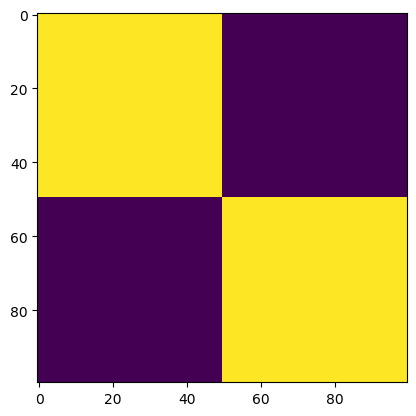

PyObject <matplotlib.image.AxesImage object at 0x000000005EB007C8>

In [15]:
ss = zeros(100,100);
ss[2,2] = 1;
imshow(ceil.(idct(ss)))

In [16]:
db = DCT_basis(100,100);


In [17]:
using JuMP, Gurobi;

In [38]:
r = 100;
domain = DCT_basis(10,10);

m = Model(Gurobi.Optimizer);
set_silent(m);

basis = @variable(m, [1:r,1:r]);
@variable(m, mu);
@constraint(m,basis.>=0);
@constraint(m,basis.<=1);
for i = 1:r
    s  = i;
    @constraint(m, sum(basis[i,:]) == s);
    
    for j = 1:r
        @constraint(m, mu >= sum(basis[i,:] .* domain[j,:]) / sqrt(s));
        @constraint(m, mu >= -sum(basis[i,:] .* domain[j,:]) / sqrt(s));
    end
end

@objective(m, Min, mu);
optimize!(m);

Academic license - for non-commercial use only
Academic license - for non-commercial use only


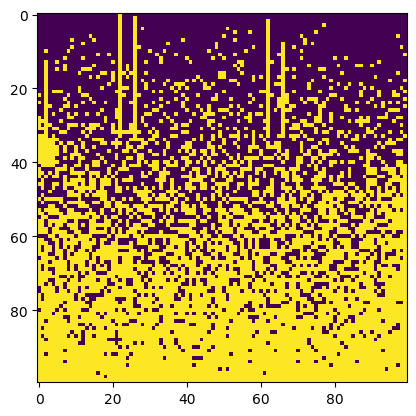

0.8607268816443397


PyObject <matplotlib.image.AxesImage object at 0x00000000020ED908>

In [39]:
println(objective_value(m))
imshow(value.(basis))

In [45]:
mu = 0;
vbasis = round.(value.(basis));
Ibasis = zeros(size(vbasis));
Ibasis = vbasis
print(vbasis[51,:] - vbasis[1,:])

for i = 1:r
    for j = 1:r
        mu_test = sum(Ibasis[i,:] .* domain[j,:]) / sum(Ibasis[i,:])^0.5;
        mu = maximum([mu,mu_test]);
    end
end

print(mu)

[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, -1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]0.8607268816443397